In [112]:
%pip install livelossplot
%pip install tensorflow
%pip install certifi


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [119]:
# Import required packages
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import cv2
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.applications import resnet, inception_v3, MobileNetV3Small, mobilenet_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras import backend as K

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [113]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


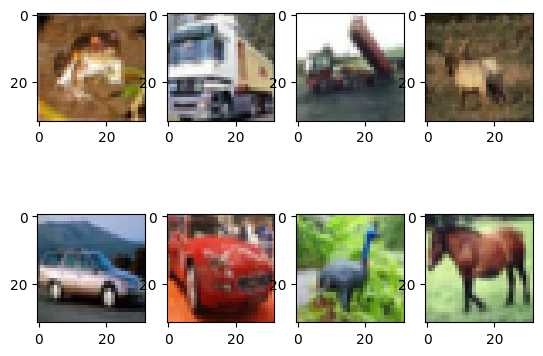

In [4]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [120]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [121]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [122]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


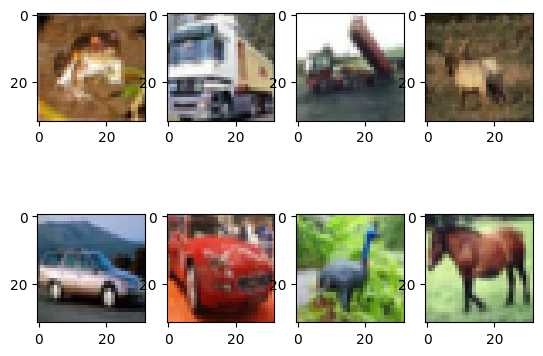

In [123]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

## 2.2. Model I (Convolutional Neural Network)

In model I, we first train our Convolutional Neural Network model with clean labels. The parameters of this CNN are updated by gradients to find the parameter with the smallest loss. This model uses 2 convolutional layers and 3 fully connected layers. Activation functions are RELU.

Epoch 1/10 - loss: 2.0971 - accuracy: 0.39% - val_loss: 0.0439 - val_accuracy: 0.46%
Epoch 2/10 - loss: 1.6495 - accuracy: 0.52% - val_loss: 0.0359 - val_accuracy: 0.58%
Epoch 3/10 - loss: 1.4656 - accuracy: 0.58% - val_loss: 0.0321 - val_accuracy: 0.63%
Epoch 4/10 - loss: 1.3280 - accuracy: 0.62% - val_loss: 0.0298 - val_accuracy: 0.66%
Epoch 5/10 - loss: 1.2224 - accuracy: 0.65% - val_loss: 0.0270 - val_accuracy: 0.69%
Epoch 6/10 - loss: 1.1155 - accuracy: 0.69% - val_loss: 0.0240 - val_accuracy: 0.73%
Epoch 7/10 - loss: 1.0356 - accuracy: 0.71% - val_loss: 0.0241 - val_accuracy: 0.72%
Epoch 8/10 - loss: 0.9754 - accuracy: 0.72% - val_loss: 0.0215 - val_accuracy: 0.75%
Epoch 9/10 - loss: 0.9256 - accuracy: 0.74% - val_loss: 0.0204 - val_accuracy: 0.77%
Epoch 10/10 - loss: 0.8594 - accuracy: 0.76% - val_loss: 0.0189 - val_accuracy: 0.78%
Model 1 training time 250.01520681381226 seconds
Finished Training


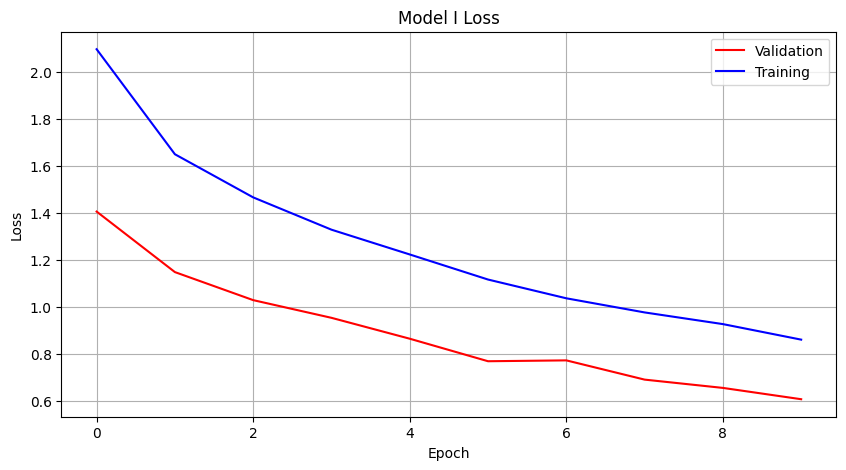

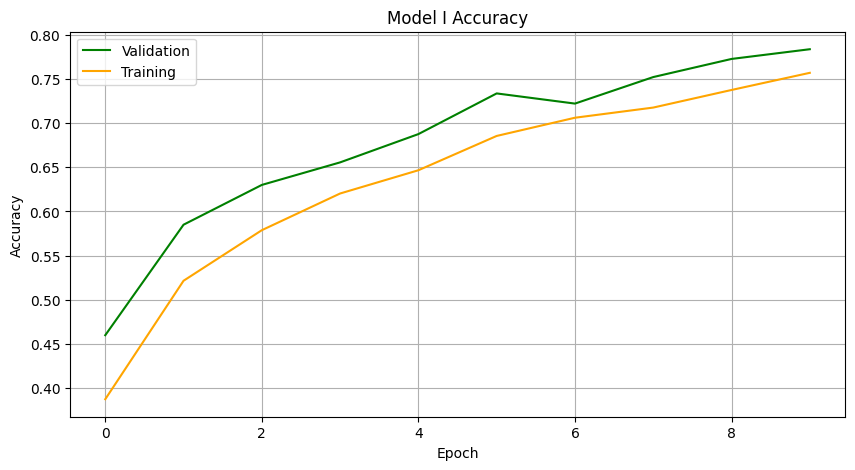

In [125]:
## Define 

# Convert images and labels into PyTorch tensors
imgs_tensor = torch.tensor(imgs.transpose((0, 3, 1, 2))).float() / 255.0  # Convert to PyTorch format and normalize
clean_labels_tensor = torch.tensor(clean_labels, dtype=torch.long) # Ensure labels are of type long

# Create a dataset and dataloader for the clean labeled data
dataset_clean = TensorDataset(imgs_tensor[:10000], clean_labels_tensor[:10000])  # Using first 10,000 images with clean labels
loader_clean = DataLoader(dataset_clean, batch_size=64, shuffle=True)


class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()
        # Increased depth and complexity
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)  # Applying dropout
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = ImprovedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Split Train and test set in clean lables
imgs_train, imgs_val, labels_train, labels_val = train_test_split(
    imgs_tensor[:10000], clean_labels_tensor[:10000], test_size=0.2, random_state=42
)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(imgs_train, labels_train)
val_dataset = TensorDataset(imgs_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

val_loss_list = []
val_accuracy_list = []
train_accuracy_list = []
train_loss_list = []

# Training loop
num_epochs = 10
startTime = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(loader_clean, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_train / total_train
    # Validate the model
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # Calculate validation loss
    val_loss /= len(val_loader)
    val_loss_list.append(val_loss)
    
    # Calculate validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.2f}% - val_loss: {val_loss/len(val_loader):.4f} - val_accuracy: {val_accuracy:.2f}%")
train_time_model_1 = time.time() - startTime
print(f'Model 1 training time {train_time_model_1} seconds')
print('Finished Training')
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(val_loss_list, label='Validation', color='red')
plt.plot(train_loss_list, label='Training', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model I Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy_list, label='Validation', color='green')
plt.plot(train_accuracy_list, label='Training', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model I Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Next, we wanted to test the accuracy of our model. We took the clean labels and performed a train test split, and then wrote two functions： one to measure the prediction accuracy and the other to visualize some examples of predictions.

In [126]:
# this function is for Validation Accuracy
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
val_accuracy_model_I = evaluate_model(model, val_loader)
print(f'Validation Accuracy of Model I: {val_accuracy_model_I:.2f}%')

Validation Accuracy of Model I: 83.45%


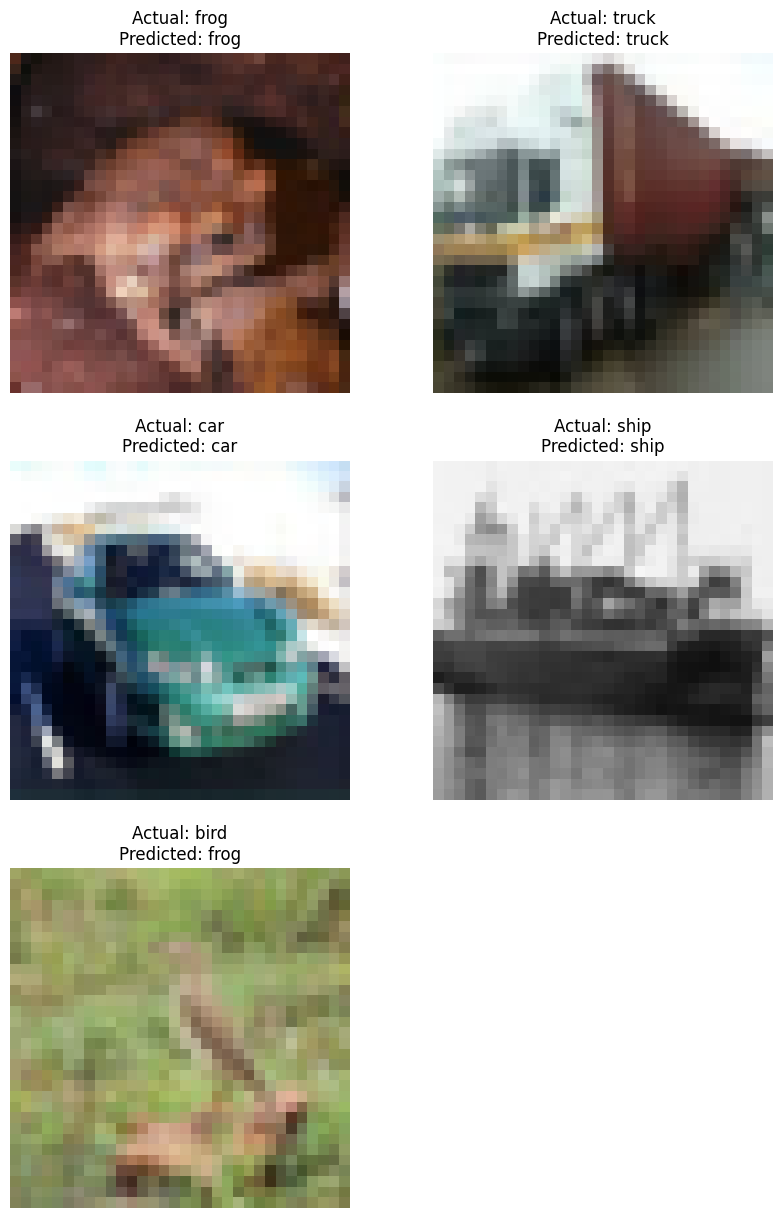

In [127]:
# this function is for visualize some examples of prediciton
def visualize_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    num_rows = np.ceil(num_images / 2).astype(int)
    plt.figure(figsize=(10, num_rows * 5))  # Adjust the figure size as needed
    for i in range(num_images):
        ax = plt.subplot(num_rows, 2, i + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Convert to numpy array and correct the channel order
        plt.imshow(img)
        plt.title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
        plt.axis('off')

# Assuming `classes` is defined (as in your provided code)
visualize_predictions(model, val_loader, classes)

Next, the trained CNN model is used in noisy labels to measure the accuracy.

Accuracy of Model I on Noisy Data: 30.18%


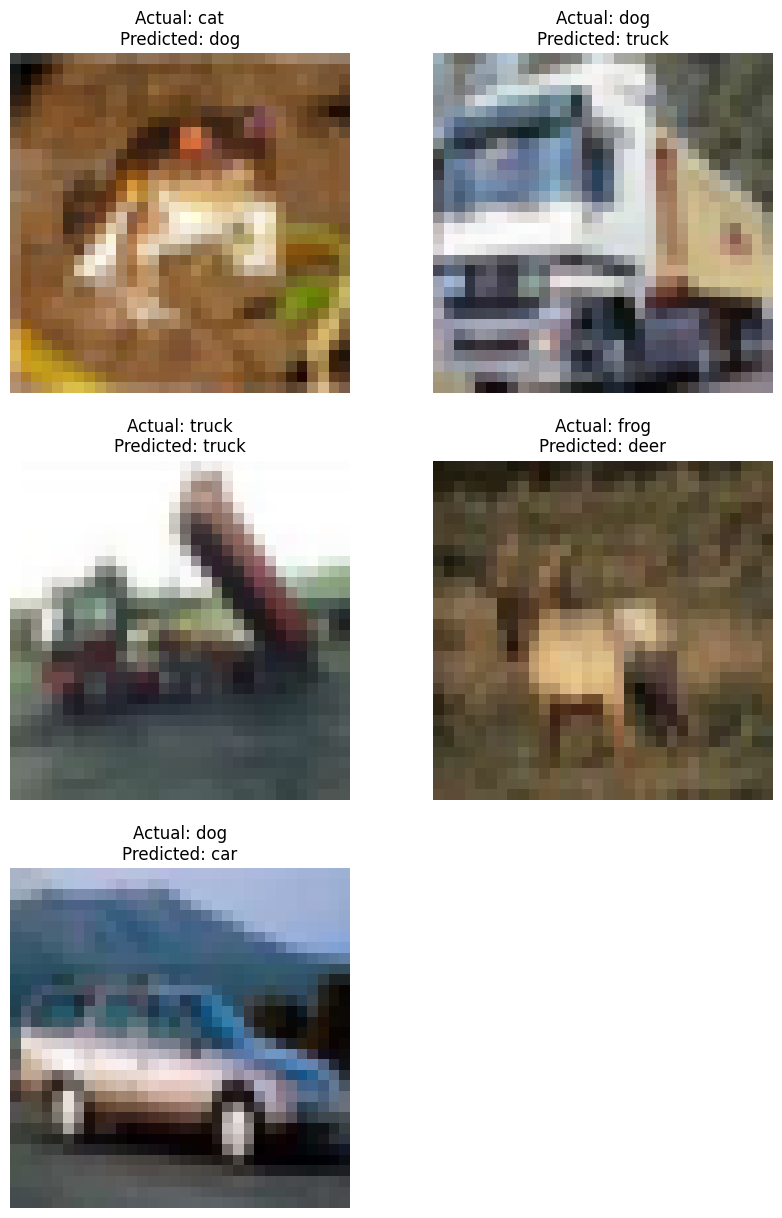

In [128]:
# Now, we use trained model to noisy labels
noisy_labels_tensor = torch.tensor(noisy_labels, dtype=torch.long)

# Since noisy_labels are for all images, we use the entire imgs_tensor
noisy_dataset = TensorDataset(imgs_tensor, noisy_labels_tensor)
noisy_loader = DataLoader(noisy_dataset, batch_size=64, shuffle=False)

# Evaluating the Models on Noisy Labels
noisy_data_accuracy_model_I = evaluate_model(model, noisy_loader)
print(f'Accuracy of Model I on Noisy Data: {noisy_data_accuracy_model_I:.2f}%')

# Visualizing Predictions On Noisy Data
visualize_predictions(model, noisy_loader, classes, num_images=5)

See the confusion matrices below to visualize the performance of model I on noisy data and clean data.

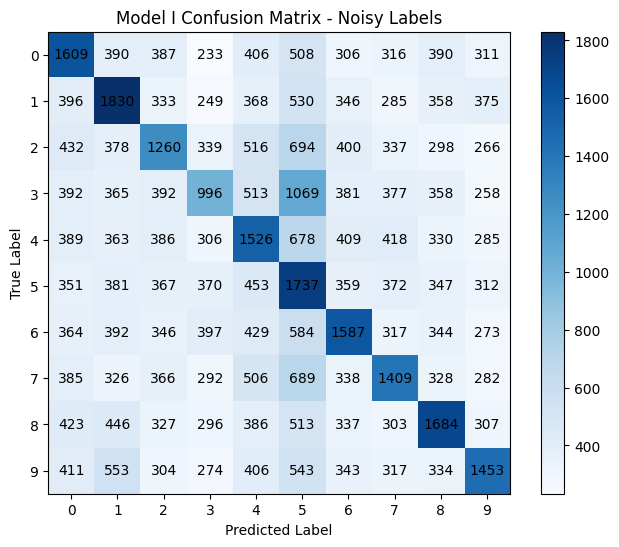

In [131]:
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in noisy_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Model I Confusion Matrix - Noisy Labels')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))
plt.show()


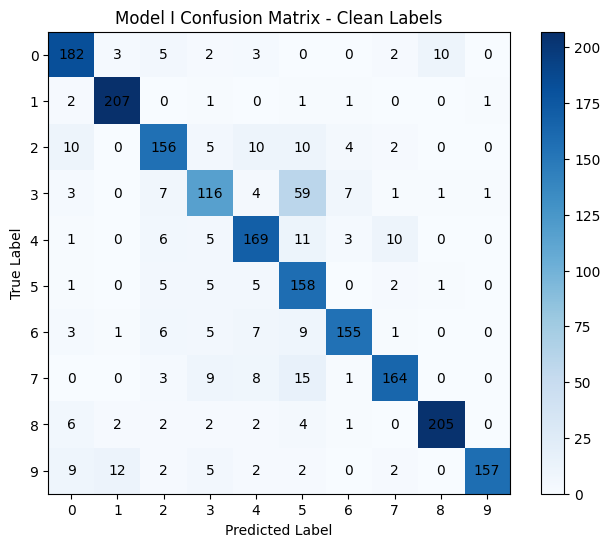

In [132]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Model I Confusion Matrix - Clean Labels')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))
plt.show()


## 2.3. Model II (InceptionV3 for Label Noise Correction and Prediction)

- In this model, we enhance the data by scaling the images to a resolution of 75 x 75 x 3, which allows for a more detailed and feature-rich representation. This is done to improve the spatial resolution. The resulting collection of images, named 'imgs_load', is stored in 'img_load.py' and divided using a ratio of 75% for training and 25% for testing.

In [83]:
imgs_load = np.empty((n_img,75,75,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs_load[i,:,:,:]=cv2.resize(cv2.imread(img_fn),(75,75),interpolation=cv2.INTER_CUBIC)

# Save the array to a numpy file
np.save('imgs_load.npy', imgs_load) 
#Re-load the imgs_load.npy under imgs_load
imgs_load = np.load('imgs_load.npy')

In [92]:
# Function to resize an image to the target size
def resize_image(img):
    resized_img = cv2.resize(img, (75, 75), interpolation=cv2.INTER_CUBIC)
    return resized_img

# Resize images
imgs_resized = np.array([resize_image(img) for img in imgs_load])

# Preprocess images for InceptionV3
imgs_inception = inception_v3.preprocess_input(imgs_load)

# Split data into training and testing sets
imgs_inception_train, imgs_inception_test, noisy_labels_train, noisy_labels_test = train_test_split(
    imgs_inception, noisy_labels, test_size=0.25, random_state=42)

# Check the shape of the resized training images
print("Shape of resized imgs_inception_train:", imgs_inception_train.shape)


Shape of resized imgs_inception_train: (37500, 75, 75, 3)


In [93]:
# loading the inception_v3 model
def create_model_inception(input_shape, n_classes, optimizer, fine_tune):
       
    # Path to the locally saved weights file
    local_weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

    conv_base = inception_v3.InceptionV3(include_top=False,
                            weights=None,input_shape=input_shape)
    conv_base.load_weights(local_weight_file)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Building the top model (fully-connected layers)    
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes * 8, activation='relu')(top_model)
    top_model = Dense(n_classes * 4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Creating and compiling the complete model
    model = Model(inputs=conv_base.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Model parameters
input_shape = (75, 75, 3)
n_classes = 10
optim = Adam(learning_rate=0.001)

# Create the model with the local InceptionV3 weights
inception_model = create_model_inception(input_shape, n_classes, optim, fine_tune=0)


In [95]:
inception_checkpoint = ModelCheckpoint('inception.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

# Splitting the data with K-Fold cross-validation
n_split = 5
kf = KFold(n_splits=n_split)

# Training loop
start_time = time.time()

for fold, (train_index, test_index) in enumerate(kf.split(imgs_inception_train), 1):
    print(f"Training on fold {fold}/{n_split}")
    x_train, x_test = imgs_inception_train[train_index], imgs_inception_train[test_index]
    y_train, y_test = noisy_labels_train[train_index], noisy_labels_train[test_index]
    
    # Train the model
    history = inception_model.fit(x_train, tf.one_hot(y_train, n_classes),
                                  validation_data=(x_test, tf.one_hot(y_test, n_classes)),
                                  batch_size=64,
                                  epochs=10,
                                  callbacks=[inception_checkpoint, early_stop],
                                  verbose=1)
    
    # Evaluate the model on the current fold
    print(f"Evaluation on fold {fold}")
    inception_model.evaluate(x_test, tf.one_hot(y_test, n_classes))

Training on fold 1/5
Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 3.0392 - accuracy: 0.1383
Epoch 1: val_loss improved from inf to 2.39120, saving model to inception.weights.best.hdf5
469/469 [==============================] - 24s 51ms/step - loss: 3.0392 - accuracy: 0.1383 - val_loss: 2.3912 - val_accuracy: 0.1505
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 2.5501 - accuracy: 0.1421
Epoch 2: val_loss improved from 2.39120 to 2.31141, saving model to inception.weights.best.hdf5
469/469 [==============================] - 25s 52ms/step - loss: 2.5501 - accuracy: 0.1421 - val_loss: 2.3114 - val_accuracy: 0.1687
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 2.3850 - accuracy: 0.1519
Epoch 3: val_loss improved from 2.31141 to 2.30109, saving model to inception.weights.best.hdf5
469/469 [==============================] - 24s 51ms/step - loss: 2.3850 - accuracy: 0.1519 - val_loss: 2.3011 - val_accuracy: 0.1561
Epoch 4/

In [88]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [97]:
inception_new = inception_v3.InceptionV3(include_top=False,
                            weights=None,input_shape=(75,75,3))

In [102]:
inception_new.load_weights('inception.weights.best.hdf5', by_name=True)
inception_new_train_output = inception_new.predict(imgs_inception) 

# Save array as .npy file
np.save('inception_new_train_output.npy', inception_new_train_output)


2024-03-20 14:46:27.234443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 47s 29ms/step


In [103]:
# the first 10,000 labels
x_train1 = inception_new_train_output[:n_clean_noisy] #labels based on above inception_new prediction
x_train2 = noisy_labels[:n_clean_noisy] #labels based on noisy labels
y_train = tf.one_hot(clean_labels,10) #labels based on clean label

In [104]:
# create array from previous prediction by transposing the matrix to 2x2 dimensions for the input
label_cleaning_input = np.concatenate((inception_new_train_output.reshape(n_img, 2048), noisy_labels.reshape(n_img, 1)), axis=1)

In [105]:
np.save('label_cleaning_input.npy', label_cleaning_input)

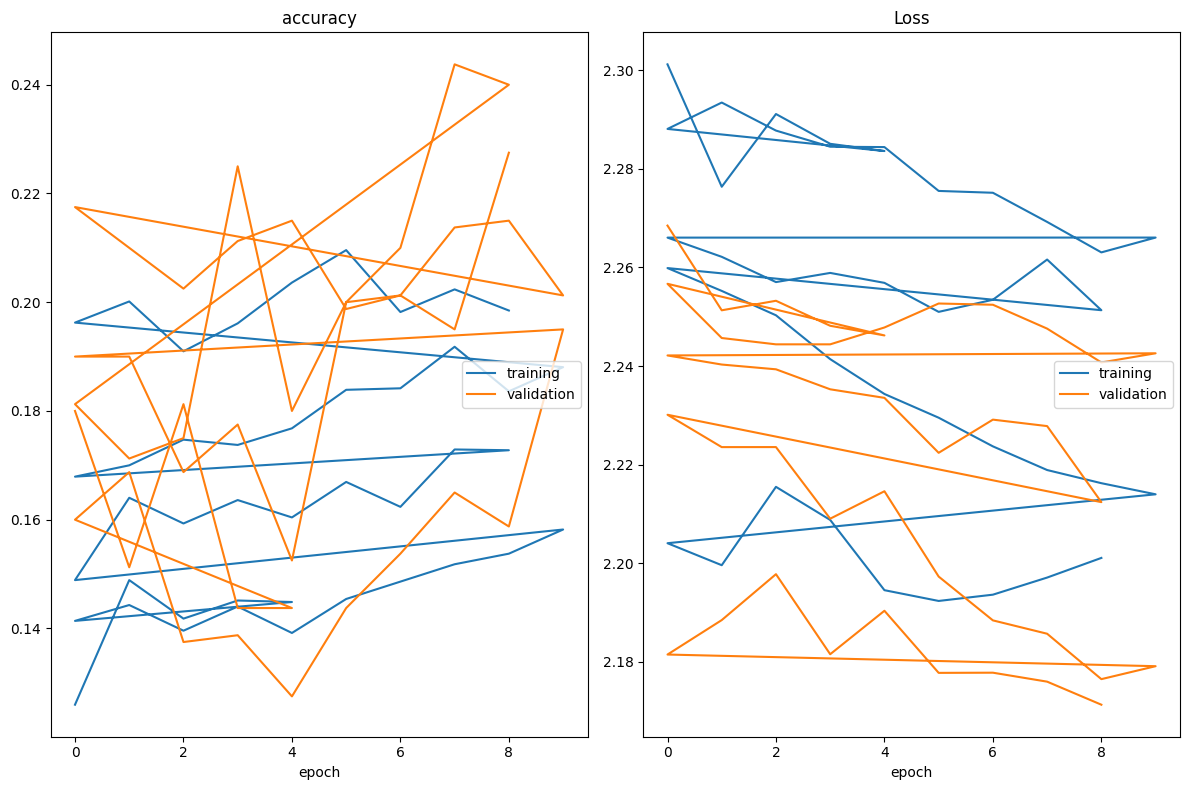

accuracy
	training         	 (min:    0.126, max:    0.210, cur:    0.198)
	validation       	 (min:    0.127, max:    0.244, cur:    0.228)
Loss
	training         	 (min:    2.192, max:    2.301, cur:    2.201)
	validation       	 (min:    2.171, max:    2.268, cur:    2.171)
63/63 [==============================] - 1s 10ms/step - loss: 2.1764 - accuracy: 0.2085
Model evaluation  [2.176377773284912, 0.2084999978542328]


In [107]:
# Design dense layers and architecture with basic CNN

label_cleaning_model = tf.keras.Sequential([
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(64, activation = 'relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(10, activation='softmax')
])

label_cleaning_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])


inception_checkpoint2 = ModelCheckpoint('labelcorrection.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop2 = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, mode='min')
plot_loss2 = PlotLossesCallback()

n_split=5

y_noisy1 = noisy_labels[:n_clean_noisy]

#train the model with inputs of image matrix from the prediction with clean label as output for the first 10,000 datasets  

for train_index,test_index in KFold(n_split).split(label_cleaning_input[:n_clean_noisy]):
  x_train,x_test=label_cleaning_input[train_index],label_cleaning_input[test_index]
  y_train,y_test=clean_labels[train_index],clean_labels[test_index]
  
  lcn_fit = label_cleaning_model.fit(x_train, 
                            tf.one_hot(y_train,10),
                            batch_size=64, 
                            epochs=10,
                            validation_split=0.1,
                            callbacks=[inception_checkpoint2, early_stop2, plot_loss2],
                            verbose=1)

  
  print('Model evaluation ',label_cleaning_model.evaluate(x_test,tf.one_hot(y_test,10)))

Epoch 1/10
  1/113 [..............................] - ETA: 37s - loss: 2.3022 - accuracy: 0.1250

2024-03-20 14:52:39.174957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - ETA: 0s - loss: 2.3101 - accuracy: 0.1226
Epoch 1: val_loss improved from inf to 2.27257, saving model to labelcorrection.weights.best.hdf5


2024-03-20 14:52:41.217442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 2s 19ms/step - loss: 2.3101 - accuracy: 0.1226 - val_loss: 2.2726 - val_accuracy: 0.1700
Epoch 2/10
111/113 [============================>.] - ETA: 0s - loss: 2.3063 - accuracy: 0.1441
Epoch 2: val_loss improved from 2.27257 to 2.25145, saving model to labelcorrection.weights.best.hdf5
113/113 [==============================] - 2s 15ms/step - loss: 2.3071 - accuracy: 0.1431 - val_loss: 2.2515 - val_accuracy: 0.1488
Epoch 3/10
111/113 [============================>.] - ETA: 0s - loss: 2.3096 - accuracy: 0.1467
Epoch 3: val_loss improved from 2.25145 to 2.24604, saving model to labelcorrection.weights.best.hdf5
113/113 [==============================] - 2s 15ms/step - loss: 2.3090 - accuracy: 0.1472 - val_loss: 2.2460 - val_accuracy: 0.1713
Epoch 4/10
110/113 [============================>.] - ETA: 0s - loss: 2.3081 - accuracy: 0.1440
Epoch 4: val_loss did not improve from 2.24604
113/113 [==============================] - 2s 14ms/step - loss: 2

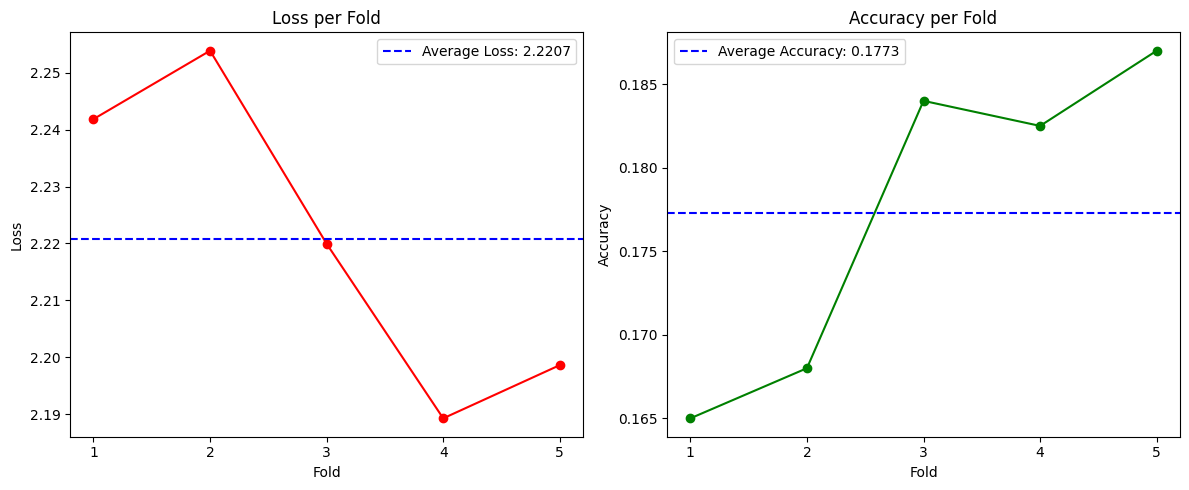

In [108]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Your existing model definition
label_cleaning_model = tf.keras.Sequential([
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(64, activation = 'relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(10, activation='softmax')
])

label_cleaning_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Callbacks
inception_checkpoint2 = ModelCheckpoint('labelcorrection.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop2 = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, mode='min')

# K-Fold Cross-Validation
n_split = 5
fold_losses = []
fold_accuracies = []

y_noisy1 = noisy_labels[:n_clean_noisy]

for train_index, test_index in KFold(n_split).split(label_cleaning_input[:n_clean_noisy]):
    x_train, x_test = label_cleaning_input[train_index], label_cleaning_input[test_index]
    y_train, y_test = clean_labels[train_index], clean_labels[test_index]
  
    label_cleaning_model.fit(x_train, 
                            tf.one_hot(y_train, 10),
                            batch_size=64, 
                            epochs=10,
                            validation_split=0.1,
                            callbacks=[inception_checkpoint2, early_stop2],
                            verbose=1)

    # Evaluate the model
    scores = label_cleaning_model.evaluate(x_test, tf.one_hot(y_test, 10), verbose=0)
    fold_losses.append(scores[0])
    fold_accuracies.append(scores[1])

# Calculate average metrics
average_loss = np.mean(fold_losses)
average_accuracy = np.mean(fold_accuracies)

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot for average loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_split + 1), fold_losses, marker='o', color='r')
plt.title('Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.xticks(range(1, n_split + 1))
plt.axhline(y=average_loss, color='b', linestyle='--', label=f'Average Loss: {average_loss:.4f}')
plt.legend()

# Plot for average accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_split + 1), fold_accuracies, marker='o', color='g')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, n_split + 1))
plt.axhline(y=average_accuracy, color='b', linestyle='--', label=f'Average Accuracy: {average_accuracy:.4f}')
plt.legend()

plt.tight_layout()
plt.show()


In [109]:
# Predict the 10,000 clean label with label cleaning network
pred_clean_labels = label_cleaning_model.predict(label_cleaning_input[n_clean_noisy:])
pred_clean_labels = pred_clean_labels.argmax(axis=-1)
new_labels = np.append(clean_labels, pred_clean_labels)
new_labels_oh = tf.one_hot(new_labels,depth=10)

  76/1250 [>.............................] - ETA: 2s

2024-03-20 14:54:26.263070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


In [110]:
# Create basic CNN fully connected layers architecture
img_class_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

img_class_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

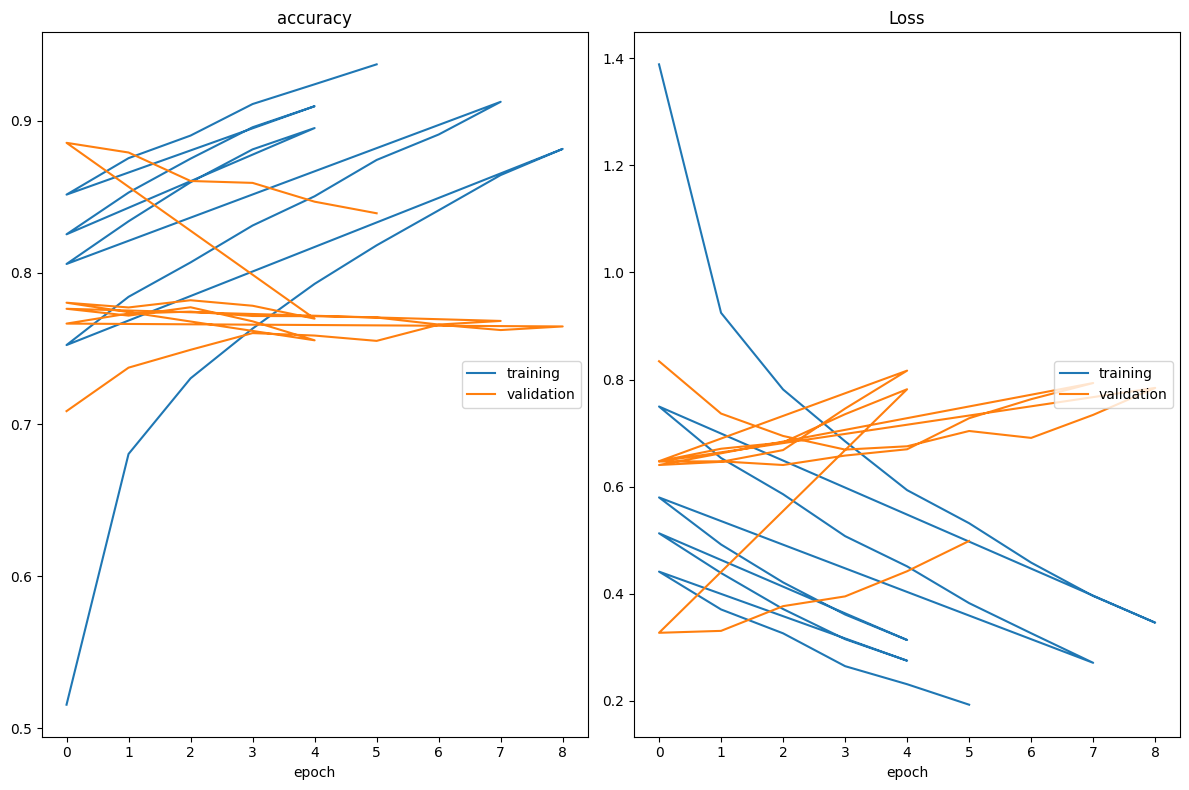

accuracy
	training         	 (min:    0.516, max:    0.937, cur:    0.937)
	validation       	 (min:    0.709, max:    0.885, cur:    0.839)
Loss
	training         	 (min:    0.193, max:    1.389, cur:    0.193)
	validation       	 (min:    0.327, max:    0.834, cur:    0.498)
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9378 - loss: 0.1857 - val_accuracy: 0.8390 - val_loss: 0.4984
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.8455 - loss: 0.4710
Model evaluation  [0.60166996717453, 0.8036999702453613]
Model Training Time: 0.66 mins


In [101]:
# Train the Model
start = time.time()
inception_checkpoint1 = ModelCheckpoint('inceptionclean.weights.best.keras', save_best_only=True, verbose=1)
early_stop1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss1 = PlotLossesCallback()

for train_index,test_index in KFold(n_split).split(inception_new_train_output):
  x_train,x_test=inception_new_train_output[train_index],inception_new_train_output[test_index]
  y_train,y_test=new_labels[train_index],new_labels[test_index]

  img_class_fit = img_class_model.fit(x_train, 
                            tf.one_hot(y_train,10),
                            batch_size=130, 
                            epochs=10,
                            validation_split=0.2, 
                            callbacks=[inception_checkpoint1,early_stop1, plot_loss1],
                            verbose=1)
  print('Model evaluation ',img_class_model.evaluate(x_test,tf.one_hot(y_test,10)))

print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')

In [112]:
img_class_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Load the weights
img_class_model.load_weights('inceptionclean.weights.best.keras')

# Make predictions on test data
start = time.time()
inceptionclean_ii_preds = img_class_model.predict(x_test)
inceptionclean_ii_preds_classes = np.argmax(inceptionclean_ii_preds, axis=1)
prediction_time = time.time() - start

# Evaluate model accuracy
inception1_acc = accuracy_score(y_test, inceptionclean_ii_preds_classes)

# Print results
print('Prediction Time:', round(prediction_time, 2), 'seconds')
print("Inception Model Accuracy: {:.2f}%".format(inception1_acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Prediction Time: 0.28 seconds
Inception Model Accuracy: 80.37%


In [114]:

def model_II(image):
    inception_preds = inception_new.predict([np.expand_dims(image, axis=0)],verbose=0);
    inception_pred_classes = np.argmax(img_class_model.predict(inception_preds,verbose=0), axis=1);
    return int(inception_pred_classes[0])

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog truck plane  deer   car   car  bird horse


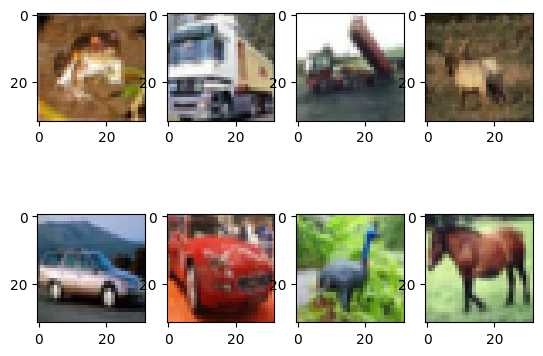

In [115]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[model_II(imgs_inception[j])] for j in range(8)))

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [9]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.